# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [8]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import Ridge
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [9]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [23]:
# function that takes raw data and completes all preprocessing required before model fits
import nltk
from nltk import word_tokenize 
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer 

nltk.download('stopwords', quiet=True, raise_on_error=True)
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(nltk.corpus.stopwords.words('english'))
tokenized_stop_words = nltk.word_tokenize(' '.join(nltk.corpus.stopwords.words('english')))

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles) if t not in stop_words]

def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        cv = CountVectorizer(tokenizer=LemmaTokenizer(), strip_accents='ascii', ngram_range=(1,2),  
                             max_df = 0.5, min_df = 5, lowercase=True, stop_words=tokenized_stop_words)
        X_cv = cv.fit_transform(movie_data['review'])
        fitted_transformations.append(cv)
        print("Shape of HashingVectorizer X:")
        print(X_cv.shape)
    else: # transform() 
        X_cv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_cv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_cv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_cv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/stephaniedang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/stephaniedang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/stephaniedang/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Create training and test sets from function

In [25]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='data/moviereviews_train.tsv', my_random_seed=24)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 115716)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9


# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [26]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

/Users/stephaniedang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(


{'Pos': 9992, 'Neg': 10008, 'TP': 5186, 'TN': 4526, 'FP': 5482, 'FN': 4806, 'Accuracy': 0.4856, 'Precision': 0.4861267341582302, 'Recall': 0.5190152121697358, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [27]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [28]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [29]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9875, 'TN': 9924, 'FP': 84, 'FN': 117, 'Accuracy': 0.98995, 'Precision': 0.9915654182146801, 'Recall': 0.9882906325060048, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [30]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [31]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=1.0)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train_alpha_1')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train_alpha_1'}


In [32]:
from sklearn import linear_model
rdg2 = linear_model.RidgeClassifier(alpha=100.0)
rdg2.fit(X_train, y_train)

rdg2_performance_train = BinaryClassificationPerformance(rdg2.predict(X_train), y_train, 'rdg_train_alpha_100')
rdg2_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train_alpha_1'}


In [33]:
from sklearn import linear_model
rdg3 = linear_model.RidgeClassifier(alpha=1000.0)
rdg3.fit(X_train, y_train)

rdg3_performance_train = BinaryClassificationPerformance(rdg3.predict(X_train), y_train, 'rdg_train_alpha_1000')
rdg3_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train_alpha_1'}


In [34]:
from sklearn import linear_model
rdg4 = linear_model.RidgeClassifier(alpha=5000.0)
rdg4.fit(X_train, y_train)

rdg4_performance_train = BinaryClassificationPerformance(rdg4.predict(X_train), y_train, 'rdg_train_alpha_5000')
rdg4_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train_alpha_1'}


In [35]:
from sklearn import linear_model
rdg5 = linear_model.RidgeClassifier(alpha=10000.0)
rdg5.fit(X_train, y_train)

rdg5_performance_train = BinaryClassificationPerformance(rdg5.predict(X_train), y_train, 'rdg_train_alpha_10000')
rdg5_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train_alpha_1'}


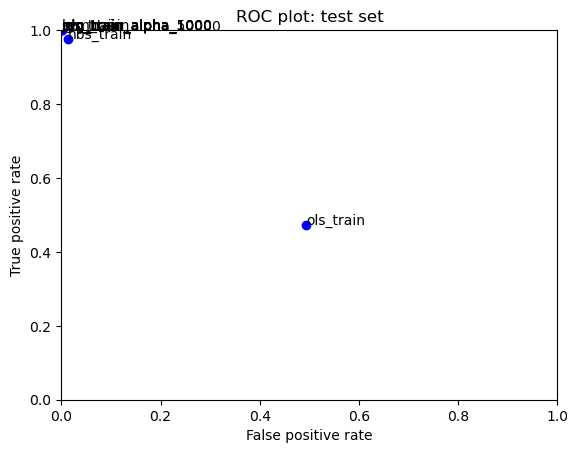

In [19]:
fits = [
        ols_performance_train,
        svm_performance_train,
        lgs_performance_train,
        nbs_performance_train,
        prc_performance_train,
        rdg_performance_train, 
        rdg2_performance_train, 
        rdg3_performance_train, 
        rdg4_performance_train, 
        rdg5_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### MODEL: Random Forest Classifier

In [36]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=10, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9223, 'TN': 8310, 'FP': 1698, 'FN': 769, 'Accuracy': 0.87665, 'Precision': 0.8445197326252175, 'Recall': 0.9230384307445957, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

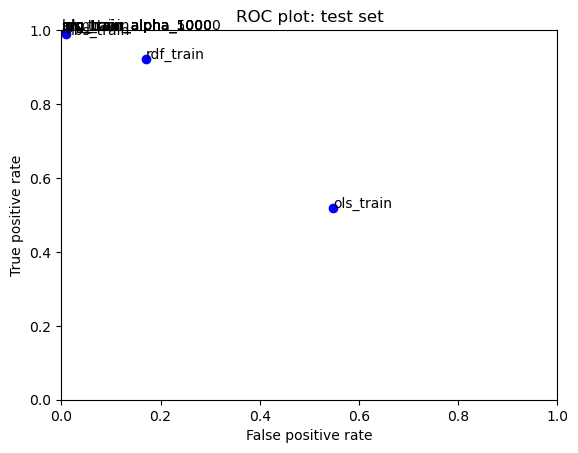

In [37]:
fits = [ols_performance_train, 
        svm_performance_train, 
        lgs_performance_train, 
        nbs_performance_train, 
        prc_performance_train, 
        rdg_performance_train, 
        rdg2_performance_train, 
        rdg3_performance_train, 
        rdg4_performance_train, 
        rdg5_performance_train,
        rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [38]:
print('OLS ROC AUC: ', roc_auc_score(y_train,ols.predict(X_train)))
print('SVM ROC AUC: ', roc_auc_score(y_train,svm.predict(X_train)))
print('LGS ROC AUC: ', roc_auc_score(y_train,lgs.predict(X_train)))
print('NBS ROC AUC: ', roc_auc_score(y_train,nbs.predict(X_train)))
print('PRC ROC AUC: ', roc_auc_score(y_train,prc.predict(X_train)))
print('RDG ROC AUC: ', roc_auc_score(y_train,rdg.predict(X_train)))
print('RDF ROC AUC: ', roc_auc_score(y_train,rdf.predict(X_train)))

OLS ROC AUC:  0.48562671080109493
SVM ROC AUC:  1.0
LGS ROC AUC:  1.0
NBS ROC AUC:  0.9899486735671511
PRC ROC AUC:  1.0
RDG ROC AUC:  1.0
RDF ROC AUC:  0.8766870810797318


### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [39]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [40]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
111
This movie was so bad it was laughable. I couldn't resist watching it though. The plot is standard, the acting quite horrible (supporting cast such as the nutty neighbor and the lawyer friend were better actors). Kind of amusing if you have some time to waste and like seeing the conclusion to a dramatic plot.<br /><br />The headliner who plays \Kathy\" was just fascinating because I couldn't decide if her deadpan, flat affect was the result of bad surgery or simply bad acting (I decided it was both). This leaves the script to comment on, which was pretty awful. Pat remarks, idiotic decisions, and reckless stupidity on the part of every character in the movie. Maybe this is what was so riveting; I don't know. I just watched it to see how bad it could be. (Actually the dialog doesn't even qualify to be called \"cliche'\" - but it's almost completely inane.)<br /><br />All in all, very bad, cheaply made movie. The sets, the same scenes (a house, a building

6170
I enjoyed \American Movie\", so I rented Chris Smith's first film, which I thought was a documentary too. In the first minute I saw that it wasn't, but I gave it a go.<br /><br />What a dead end film. Being true-to-life hardly serves you if you're merely going to examine tediousness, esp. tediousness that we're already familar with.<br /><br />I'm sorry, but will it come as a relevation to ANYONE that 1) a lot of jobs suck and 2) most of them are crappy, minimum wage jobs in the service sector??? I knew that before I saw the film. It didn't really provide an examination of that anyway, as while the film struggles to feel \"real\" (handheld camera, no music, etc.), what's going on hardly plays out as it would in the \"real world.\"<br /><br />Would an employer be so cheerful to Randy when he picks up his check, after Randy quit on him after 3 days when the guy said he expected him to stay 6 months?? Or the day after abandoning his job (and screwing up the machine he was working on)

10727
I had high hopes for this film, because I thought CLEAN, SHAVEN (Kerrigan's first feature) was absolutely terrific, the most assuredly cinematic low budget film I'd ever seen.<br /><br />But much of CLAIRE DOLAN is utterly pointless and flat. Scene after scene seems randomly tossed into the mix, without much thought for narrative or character.<br /><br />Is Claire trying to escape being a prostitute or not? Hard to tell. Why does she pick up the trick at the airport if she wants to escape that life? Why does she then not pick up tricks when she needs money in Seattle? Why do we have to see her dye her hair to what is virtually the exact same color? Why does Claire accept some johns and not others? The filmmaker doesn't seem to know.<br /><br />It feels as if everything is improvised (though I understand this wasn't the case) and the filmmakers just held a camera on it as if they were making a verite documentary.<br /><br />After the screening I saw, Kerrigan defended his lack of 

15484
I first saw this when it was picked as a suggestion from my TiVo system. I like Danny Elfman and thought it might be interesting. On top of that, I'm a fan of Max Fleischer's work, and this started out with the look and feel of his 30s cartoon. With both of those, I thought it would hold my interest. I was wrong. Just a few minutes in, and I had the fast forward button down. I ran through it in about 15 minutes, and thought that was it.<br /><br />Afterwards, I read some of the other reviews here and figured I didn't give it enough of a chance. I recorded it again and watched it through. There's 75 minutes of my life I'm not getting back.<br /><br />I can't believe there aren't more bad reviews. Personally, I think it's because it's hard to get to the 10 line comment minimum. How many ways are there to say this is a waste of time?<br /><br />The movie comes across as though it was made by a few junior high kids ready to outrage the world and thinking they can with breasts, profan

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [41]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 1301, 'TN': 1055, 'FP': 1437, 'FN': 1207, 'Accuracy': 0.4712, 'Precision': 0.4751643535427319, 'Recall': 0.5187400318979266, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [42]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2132, 'TN': 2104, 'FP': 388, 'FN': 376, 'Accuracy': 0.8472, 'Precision': 0.846031746031746, 'Recall': 0.8500797448165869, 'desc': 'svm_test'}


### MODEL: logistic regression

In [43]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2112, 'TN': 2112, 'FP': 380, 'FN': 396, 'Accuracy': 0.8448, 'Precision': 0.8475120385232745, 'Recall': 0.8421052631578947, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [44]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2124, 'TN': 2121, 'FP': 371, 'FN': 384, 'Accuracy': 0.849, 'Precision': 0.8513026052104209, 'Recall': 0.84688995215311, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [45]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2128, 'TN': 2125, 'FP': 367, 'FN': 380, 'Accuracy': 0.8506, 'Precision': 0.8529058116232465, 'Recall': 0.8484848484848485, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [46]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test_alpha_1')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2221, 'TN': 2165, 'FP': 327, 'FN': 287, 'Accuracy': 0.8772, 'Precision': 0.8716640502354788, 'Recall': 0.8855661881977671, 'desc': 'rdg_test_alpha_1'}


In [47]:
rdg2_performance_test = BinaryClassificationPerformance(rdg2.predict(X_test), y_test, 'rdg_test_alpha_100')
rdg2_performance_test.compute_measures()
print(rdg2_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2223, 'TN': 2166, 'FP': 326, 'FN': 285, 'Accuracy': 0.8778, 'Precision': 0.8721067085131424, 'Recall': 0.8863636363636364, 'desc': 'rdg_test_alpha_100'}


In [48]:
rdg3_performance_test = BinaryClassificationPerformance(rdg3.predict(X_test), y_test, 'rdg_test_alpha_1000')
rdg3_performance_test.compute_measures()
print(rdg3_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2225, 'TN': 2170, 'FP': 322, 'FN': 283, 'Accuracy': 0.879, 'Precision': 0.8735767569689831, 'Recall': 0.8871610845295056, 'desc': 'rdg_test_alpha_1000'}


In [49]:
rdg4_performance_test = BinaryClassificationPerformance(rdg4.predict(X_test), y_test, 'rdg_test_alpha_5000')
rdg4_performance_test.compute_measures()
print(rdg4_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2237, 'TN': 2182, 'FP': 310, 'FN': 271, 'Accuracy': 0.8838, 'Precision': 0.878288182175108, 'Recall': 0.8919457735247209, 'desc': 'rdg_test_alpha_5000'}


In [50]:
rdg5_performance_test = BinaryClassificationPerformance(rdg5.predict(X_test), y_test, 'rdg_test_alpha_10000')
rdg5_performance_test.compute_measures()
print(rdg5_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2244, 'TN': 2190, 'FP': 302, 'FN': 264, 'Accuracy': 0.8868, 'Precision': 0.8813825608798115, 'Recall': 0.8947368421052632, 'desc': 'rdg_test_alpha_10000'}


### MODEL: Random Forest Classifier

In [51]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2193, 'TN': 1962, 'FP': 530, 'FN': 315, 'Accuracy': 0.831, 'Precision': 0.8053617333822989, 'Recall': 0.8744019138755981, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

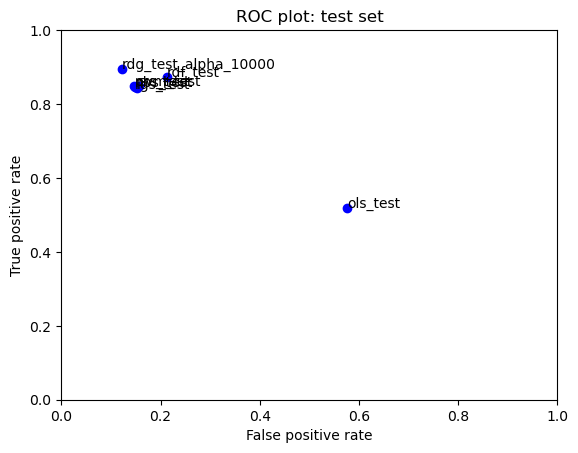

In [54]:
fits = [ols_performance_test, 
        svm_performance_test, 
        lgs_performance_test, 
        nbs_performance_test, 
        prc_performance_test, 
        #rdg_performance_test,
        #rdg2_performance_test,
        #rdg3_performance_test,
        #rdg4_performance_test,
        rdg5_performance_test,
        rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [53]:
print('OLS ROC AUC: ', roc_auc_score(y_test,ols.predict(X_test)))
print('SVM ROC AUC: ', roc_auc_score(y_test,svm.predict(X_test)))
print('LGS ROC AUC: ', roc_auc_score(y_test,lgs.predict(X_test)))
print('NBS ROC AUC: ', roc_auc_score(y_test,nbs.predict(X_test)))
print('PRC ROC AUC: ', roc_auc_score(y_test,prc.predict(X_test)))
print('RDG ROC AUC: ', roc_auc_score(y_test,rdg.predict(X_test)))
print('RDG2 ROC AUC: ', roc_auc_score(y_test,rdg2.predict(X_test)))
print('RDG3 ROC AUC: ', roc_auc_score(y_test,rdg3.predict(X_test)))
print('RDG4 ROC AUC: ', roc_auc_score(y_test,rdg4.predict(X_test)))
print('RDG5 ROC AUC: ', roc_auc_score(y_test,rdg5.predict(X_test)))
print('RDF ROC AUC: ', roc_auc_score(y_test,rdf.predict(X_test)))

OLS ROC AUC:  0.47104738352520736
SVM ROC AUC:  0.8471907552333335
LGS ROC AUC:  0.8448086508405845
NBS ROC AUC:  0.8490067738293641
PRC ROC AUC:  0.8506067902135318
RDG ROC AUC:  0.8771731422529766
RDG2 ROC AUC:  0.8777725083904859
RDG3 ROC AUC:  0.878973800691719
RDG4 ROC AUC:  0.8837738498442225
RDG5 ROC AUC:  0.8867745205710906
RDF ROC AUC:  0.8308606680132403


---

# <span style="color:red">SUBMISSION</span>

---

In [55]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='data/moviereviews_test.tsv', my_random_seed=24, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 115716)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Size

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

### Submission 4: I'll be switching back to the Ridge Regression Classifier fit.

In [56]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg5.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.48716


In [57]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [58]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,0
3,7186_2,1
4,12128_7,1


In [59]:
my_submission.shape

(25000, 2)

In [60]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/stephaniedang/Documents/Documents/MSDV_Spring_2023/Machine_Learning/assignment1/moviereviews_submission4.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation